## 1. IMPORTING ESSENTIAL LIBRARIES

In [95]:
#manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

#this is just cool
from tqdm import tqdm

#visualization
%matplotlib inline

#natural language processing
import string
import re
from nltk.corpus import stopwords

#stemming/lemmatizing/vectorizing/Spell Checking
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from autocorrect import Speller

# Splitting dataset
from sklearn.model_selection import train_test_split


from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
import tensorflow as tf 
from keras import Input
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU 
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K


# Custom Functions
import FeatureCreation as fc
import text_cleaner as tc
import vizualization as viz


#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

## 2. IMPORTING THE DATASET FOR PROCESSING AND CLASSIFICATION

In [2]:
# importing and reviewing the top 5 tweets in the training dataset
train_df = pd.read_csv("dataset/train.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Importing and reviewing the top 5 tweets in the testing dataset
test_df = pd.read_csv('dataset/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 3. FEATURE EXPLORATION

  EXPLORING THE DATASET SHAPE AND FEATURE DISTRIBUTION

In [4]:
# Train dataset shape
print("Train dataset shape: ", train_df.shape)
print("Train dataset memory usage: {:.2} MB".format(train_df.memory_usage(index=True, deep=True).sum()/1024**2))

Train dataset shape:  (7613, 5)
Train dataset memory usage: 2.2 MB


In [5]:
# Test dataset shape and memory usage
print("Test dataset shape: ", test_df.shape)
print("Test dataset memeory usage: {:.2} MB".format(test_df.memory_usage(index=True, deep=True).sum()/1024**2))

Test dataset shape:  (3263, 4)
Test dataset memeory usage: 0.91 MB


In [6]:
# Checking missing values in the train dataset
# It is clear that 'location' feature has significant number of missing values,
# 'keyword' feature has some missing values as well

train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# Checking missing values test dataset
# we can see that 'location'feature has significant number of missing values,
# likewise, 'keyword' feature has some missing values as well

# Missing values in the features in testdataset
# we can see that 'location' has significant number of missing values,
# 'keyword' has some missing values as well

test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

 It looks like we have proportionally more missing values in the 'location' feature and 
 slightly some missing values in the 'keyword' feature

 Let us see the percentage of missing values

In [8]:
# 'location' feature missing values in train and test dataset


print("'location' feature has {:.4} % missing values in train dataset and {:.4} % missing values in the test dataset".format((train_df['location'].isnull().sum()*100/len(train_df)), test_df['location'].isnull().sum()*100/len(test_df)))

'location' feature has 33.27 % missing values in train dataset and 33.86 % missing values in the test dataset


In [9]:
## since location has a lot of missing values and less important for our analysis, 

## Dropping 'location' 

train_df.drop('location', axis=1, inplace=True)
test_df.drop('location', axis=1, inplace=True)

In [10]:
# 'Keyword' feature missing values in train and test dataset
print("'keyword' feature has {:.3} % missing values in train dataset and {:.3} % missing values in the test dataset".format((train_df['keyword'].isnull().sum()*100/len(train_df)), test_df['keyword'].isnull().sum()*100/len(test_df)))

'keyword' feature has 0.801 % missing values in train dataset and 0.797 % missing values in the test dataset


In [11]:
# Checking if the most popular keywords in disaster and no disaster tweets are different

train_df[train_df['target']==1].groupby('keyword').head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7508,10739,wreckage,MH370 victim's family furious the media was to...,1
7509,10741,wreckage,Wreckage 'Conclusively Confirmed' as From MH37...,1
7552,10795,wrecked,Israel wrecked my home. Now it wants my land. ...,1
7559,10808,wrecked,300K exotic car wrecked in train accident \nht...,1


#### INFERENCE

The missing values in 'location' feature in both train and test datasets is proportionally equal and likewise for the 'keyword' feature. 

From the above analysis of missing values, although not certain, there is high probablity that training and test datasets are taken from the same sample. 

### Examining Class balancing

In [12]:
# Distribution of taget value in the training dataset

train_disaster_count = train_df[train_df['target']==1]['target'].count()
train_no_distaster_count = len(train_df) - train_disaster_count

print("The training dataset has {:.4}%  disaster tweets and {:.4}% no disaster tweets.".format(train_disaster_count*100/len(train_df), train_no_distaster_count*100/len(train_df)))

The training dataset has 42.97%  disaster tweets and 57.03% no disaster tweets.


As we can see above, the classes are comparably similar and since there is no significant difference between them - no special treatment is necessary.

Visual presentation of class distribution follows:

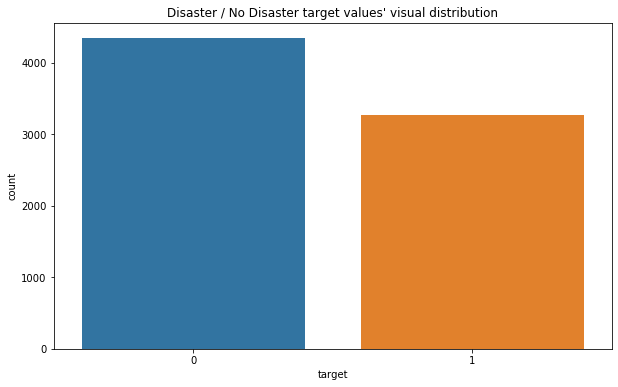

In [13]:
# Figure size
plt.subplots(figsize=(10,6))

# Creating a count plot
sns.countplot(x='target', data=train_df)

# title
plt.title("Disaster / No Disaster target values' visual distribution")
plt.show()

Let us focus only on the text data under 'text' feature name for our analysis:

   - Since the ID will be used for submission purposes, we will keep the ID under a new variable

   - However, we will drop 'keyword' and 'location' features for the analysis


In [14]:
# Saving the ID and keyword features
train_features = train_df[['id','keyword']]
test_features = test_df[['id', 'keyword']]
train_features.head()

,id,keyword
0,1,NaN
1,4,NaN
2,5,NaN
3,6,NaN
4,7,NaN


In [15]:
# Dropping 'id', 'location' and 'keyword' from training and testing datasets

dropping_columns = ['id', 'keyword']
train_df.drop(dropping_columns, axis = 1, inplace=True)
test_df.drop(dropping_columns, axis=1, inplace=True)
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
# Checking testing dataset dimensions after dropping features
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


## 4. FEATURE CREATION

    In this section, we will create some more features that might help our classification
        These features are derived from the text data and include:
            + Word Count
            + Unique Word Count
            + Charcter Count
            + Stop Word Count
            + Punctuation Count
            + Mean Word Length
            + Mention Count
            + URL Count
            + Hashtag Count

### Word Count

In [17]:

train_df = fc.word_count(train_df)
test_df = fc.word_count(test_df)

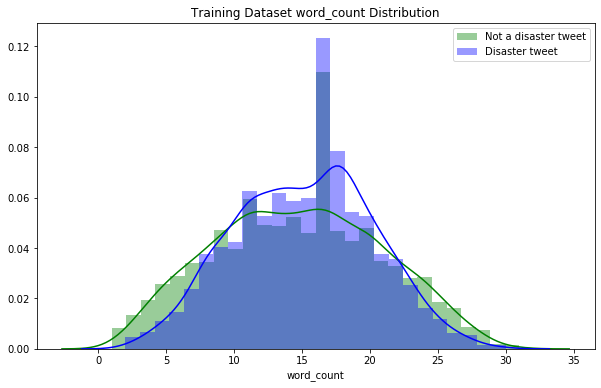

In [18]:
viz.distribution_plot(train_df, 'word_count')

### Unique Word Count

In [19]:
# Creating Unique Word Count feature in training and testing datasets

train_df = fc.unique_word_count(train_df)
test_df = fc.unique_word_count(test_df)

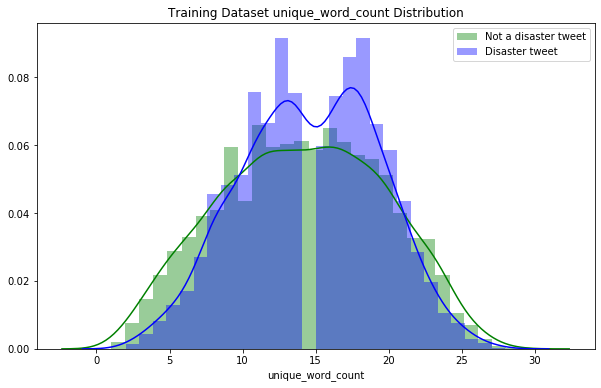

In [20]:
# Visual distribution of Unique Word Count agaist the target values

viz.distribution_plot(train_df, 'unique_word_count')

### Character Count

In [21]:
# Creating Character Count feature in training and testing datasets

train_df = fc.character_count(train_df)
test_df = fc.character_count(test_df)

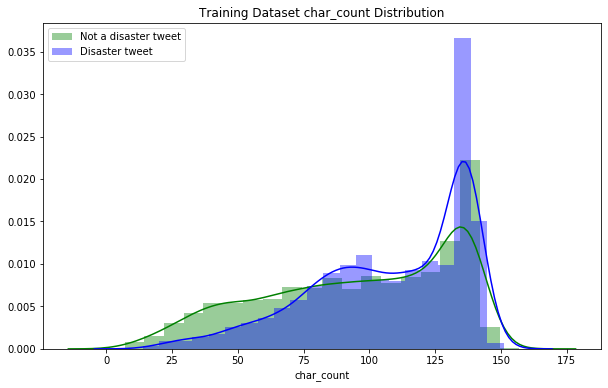

In [22]:
# Visual distribution of character count agaist the target values

viz.distribution_plot(train_df, 'char_count')

### StopWord Count

In [23]:
# Creating Stop Word Count feature in training and testing datasets
train_df = fc.stopwords_count(train_df)
test_df = fc.stopwords_count(test_df)

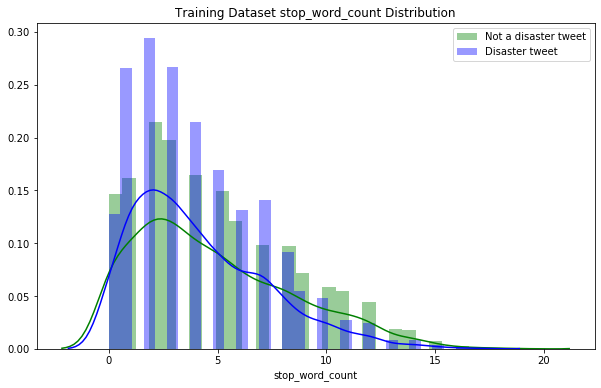

In [24]:
# Visual distribution of stop word count agaist the target values

viz.distribution_plot(train_df, 'stop_word_count')

### Punctuation Count

In [25]:
# Punctuation counts in training and testing datasets
train_df = fc.punctuation_count(train_df)
test_df = fc.punctuation_count(test_df)

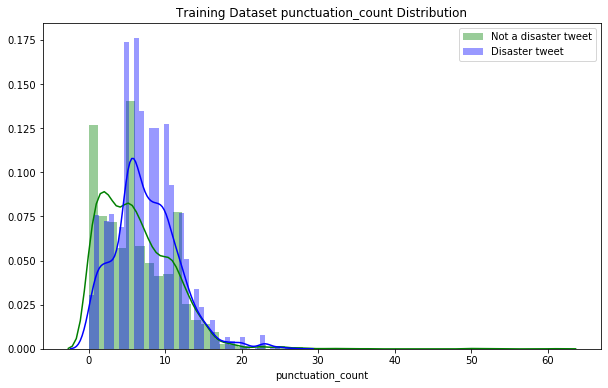

In [26]:
# Visual distribution of punctuation count agaist the target values

viz.distribution_plot(train_df, 'punctuation_count')

### Mean Word Length

In [27]:
# Creating Mean Word Length feature in training and testing datasets

train_df = fc.mean_word_length(train_df)
test_df = fc.mean_word_length(test_df)

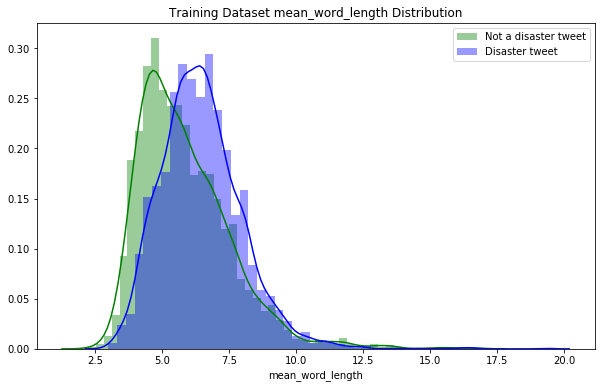

In [28]:
# Visual distribution of mean word length agaist the target values

viz.distribution_plot(train_df, 'mean_word_length')

### Mention Count

In [29]:
# Creating Mention Count feature in training and testing datasets
# We use the character @ to locate a mention

train_df = fc.mention_count(train_df)
test_df = fc.mention_count(test_df)

In [35]:
# Visual distribution of mention count agaist the target values
viz.distribution_plot(train_df, 'mention_count')


### URL Count

In [36]:
# Creating URL Count feature in training and testing datasets

train_df = fc.url_count(train_df)
test_df = fc.url_count(test_df)

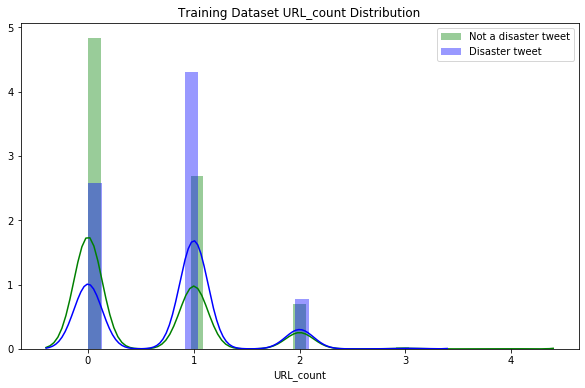

In [37]:
# Visual distribution of URL count agaist the target values

viz.distribution_plot(train_df, 'URL_count')

### Hashtag Count

In [38]:
# Creating Hashtag Count feature in training and testing datasets

train_df = fc.hashtag_count(train_df)
test_df = fc.hashtag_count(test_df)

In [ ]:
# Visual distribution of hashtag count agaist the target values

viz.distribution_plot(train_df, 'hashtag_count')

## 5. TEXT DATA CLEANING

In cleaning the text data, It is advisable first to fix potential abbreviations(such as I'm for I am) to avoid possible letter separations when removing the punctuation symbols.

        + Hence, the abbreviations will be substituted first using Regular Expressions.
        + Remove punctuation
        + Remove StopWords
        + Remove text with less characters
        + Remove non alphabet
        + Stemming words 
        + Lemmatize words (noun)
        + Lemmatize words (pronoun)
        + Spell Check

In [40]:
# Checking 'clean' function
tweet = "I'm can't ain't won't didn't"
print(tc.clean(tweet))

I am cannot am not will not did not


### Cleaning Text

In [41]:
# Substitute abbreviations in training and testing datasets
clean_train_df = train_df['text'].apply(tc.clean)
clean_test_df = test_df['text'].apply(tc.clean)

In [42]:
clean_train_df = pd.DataFrame(clean_train_df, columns=['text'])
clean_test_df = pd.DataFrame(clean_train_df, columns=['text'])
clean_train_df.head()

,text
0,Our Deeds are the Reason of this # earthquake...
1,Forest fire near La Ronge Sask . Canada
2,All residents asked to ' shelter in place ' ...
3,"13,000 people receive # wildfires evacuation ..."
4,Just got sent this photo from Ruby # Alaska a...


In [43]:
# chaning the text features to lowercase for convenience
clean_train_df['text'] = clean_train_df['text'].apply(lambda s: s.lower())
clean_test_df['text'] = clean_test_df['text'].apply(lambda s: s.lower())

### Remove URL

In [44]:
clean_train_df = tc.remove_url(clean_train_df)
clean_test_df = tc.remove_url(clean_test_df)

### Remove Punctuation

In [45]:

clean_train_df = tc.remove_punctuation(clean_train_df)
clean_test_df = tc.remove_punctuation(clean_test_df)

### Remove StopWords

In [46]:

clean_train_df = tc.remove_stopwords(clean_train_df)
clean_test_df = tc.remove_stopwords(clean_test_df)

### Remove Short Words

In [47]:
clean_train_df = tc.remove_shorter_than(clean_train_df)
clean_test_df = tc.remove_shorter_than(clean_test_df)

### Remove Non-Alphabetic Words

In [48]:

clean_train_df = tc.remove_non_alphabets(clean_train_df)
clean_test_df = tc.remove_non_alphabets(clean_test_df)

In [49]:
clean_train_df.head()

,text
0,deeds reason earthquake may allah forgive
1,forest fire near ronge sask canada
2,residents asked shelter place notified officer...
3,people receive wildfires evacuation orders cal...
4,got sent photo ruby alaska smoke wildfires pou...


### Stemming

In [50]:
clean_train_df = tc.stemming(clean_train_df)
clean_test_df = tc.stemming(clean_test_df)

### Lemmatizing

In [51]:
clean_train_df = tc.lemmatizing(clean_train_df)
clean_test_df = tc.lemmatizing(clean_test_df)

In [52]:
labels = train_df['target']
labels

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

### Tokenization

In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [54]:
token = Tokenizer()

In [55]:
text = clean_train_df['text'].tolist()
text[:3]

['deeds reason earthquake may allah forg',
 'forest fire near ronge sask canada',
 'residents asked shelter place notified officers evacuation shelter place orders expect']

In [56]:
token.fit_on_texts(text)

In [57]:
vocab_size = len(token.word_index) + 1
vocab_size

15776

In [58]:
text_encode = token.texts_to_sequences(text)

In [59]:
print(text_encode[:5])

[[6182, 680, 226, 51, 1411, 6183], [89, 4, 115, 6184, 6185, 1034], [1710, 1412, 1711, 606, 6186, 1536, 165, 1711, 606, 1204, 816], [6, 4228, 1712, 165, 1204, 20], [28, 1108, 123, 6187, 1713, 180, 1712, 6188, 82]]


In [60]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 120
X = pad_sequences(text_encode, maxlen=max_length, padding='post')

In [61]:
print(X)

[[6182  680  226 ...    0    0    0]
 [  89    4  115 ...    0    0    0]
 [1710 1412 1711 ...    0    0    0]
 ...
 [ 569  383 1400 ...    0    0    0]
 [  12  957 2953 ...    0    0    0]
 [ 103  141  386 ...    0    0    0]]


In [62]:
X.shape

(7613, 120)

## Word Embedding - Glove Vectors

In [63]:
glove_vectors = dict() 

In [64]:
%%time 
file  = open('dataset/glove.twitter.27B.200d.txt','r', encoding="utf-8")

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    glove_vectors[word] = vectors
file.close()

CPU times: user 44.8 s, sys: 3.92 s, total: 48.8 s
Wall time: 49.9 s


In [65]:
len(glove_vectors.keys())

1193514

In [66]:
vec_size = glove_vectors.get('me').shape[0]
vec_size

200

In [67]:
word_vector_matrix = np.zeros((vocab_size, 200))

In [68]:
for word, index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector

In [69]:
X_df = pd.DataFrame(data=X)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,6182,680,226,51,1411,6183,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,89,4,115,6184,6185,1034,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1710,1412,1711,606,6186,1536,165,1711,606,1204,...,0,0,0,0,0,0,0,0,0,0
3,6,4228,1712,165,1204,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,1108,123,6187,1713,180,1712,6188,82,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
train_df.drop(['target', 'text'], axis=1, inplace=True)

In [71]:
train_df.head()

,word_count,unique_word_count,char_count,stop_word_count,punctuation_count,mean_word_length,mention_count,URL_count,hashtag_count
0,13,13,69,6,1,4.384615,0,0,1
1,7,7,38,0,1,4.571429,0,0,0
2,22,20,133,11,3,5.090909,0,0,0
3,8,8,65,1,2,7.125000,0,0,1
4,16,15,88,7,2,4.500000,0,0,2


In [72]:
train_df.shape

(7613, 9)

In [73]:
training_df = pd.concat([X_df, train_df], axis=1, sort=False)
training_df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,word_count,unique_word_count,char_count,stop_word_count,punctuation_count,mean_word_length,mention_count,URL_count,hashtag_count
0,6182,680,226,51,1411,6183,0,0,0,0,...,0,13,13,69,6,1,4.384615,0,0,1
1,89,4,115,6184,6185,1034,0,0,0,0,...,0,7,7,38,0,1,4.571429,0,0,0
2,1710,1412,1711,606,6186,1536,165,1711,606,1204,...,0,22,20,133,11,3,5.090909,0,0,0
3,6,4228,1712,165,1204,20,0,0,0,0,...,0,8,8,65,1,2,7.125000,0,0,1
4,28,1108,123,6187,1713,180,1712,6188,82,0,...,0,16,15,88,7,2,4.500000,0,0,2


# Model Building

In [74]:
## splitting the training data into train and testing set

X_train, X_test, y_train, y_test = train_test_split(training_df, labels, random_state=42, test_size = 0.2, stratify=labels)

## CNN Model

### Training with additional features

In [78]:


model = Sequential()

model.add(Embedding(vocab_size, vec_size, input_length=129, weights=[word_vector_matrix], trainable=False))

model.add(Conv1D(64, 8, activation='relu'))

model.add(MaxPooling1D(2))

model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 129, 200)          3155200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 64)           102464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 64)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 61, 32)            2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 61, 32)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 61, 16)           

In [80]:
history = model.fit(X_train, y_train, epochs=30, validation_data = (X_test, y_test))

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 6s 952us/sample - loss: 0.6245 - accuracy: 0.6617 - val_loss: 0.4892 - val_accuracy: 0.7938
Epoch 2/30
6090/6090 [==============================] - 5s 785us/sample - loss: 0.5012 - accuracy: 0.7700 - val_loss: 0.4604 - val_accuracy: 0.8063
Epoch 3/30
6090/6090 [==============================] - 5s 786us/sample - loss: 0.4574 - accuracy: 0.7929 - val_loss: 0.4399 - val_accuracy: 0.8129
Epoch 4/30
6090/6090 [==============================] - 5s 809us/sample - loss: 0.4376 - accuracy: 0.8110 - val_loss: 0.4346 - val_accuracy: 0.8181
Epoch 5/30
6090/6090 [==============================] - 5s 813us/sample - loss: 0.4110 - accuracy: 0.8179 - val_loss: 0.4302 - val_accuracy: 0.8168
Epoch 6/30
6090/6090 [==============================] - 5s 791us/sample - loss: 0.3870 - accuracy: 0.8378 - val_loss: 0.4295 - val_accuracy: 0.8083
Epoch 7/30
6090/6090 [==============================] - 5s 827us

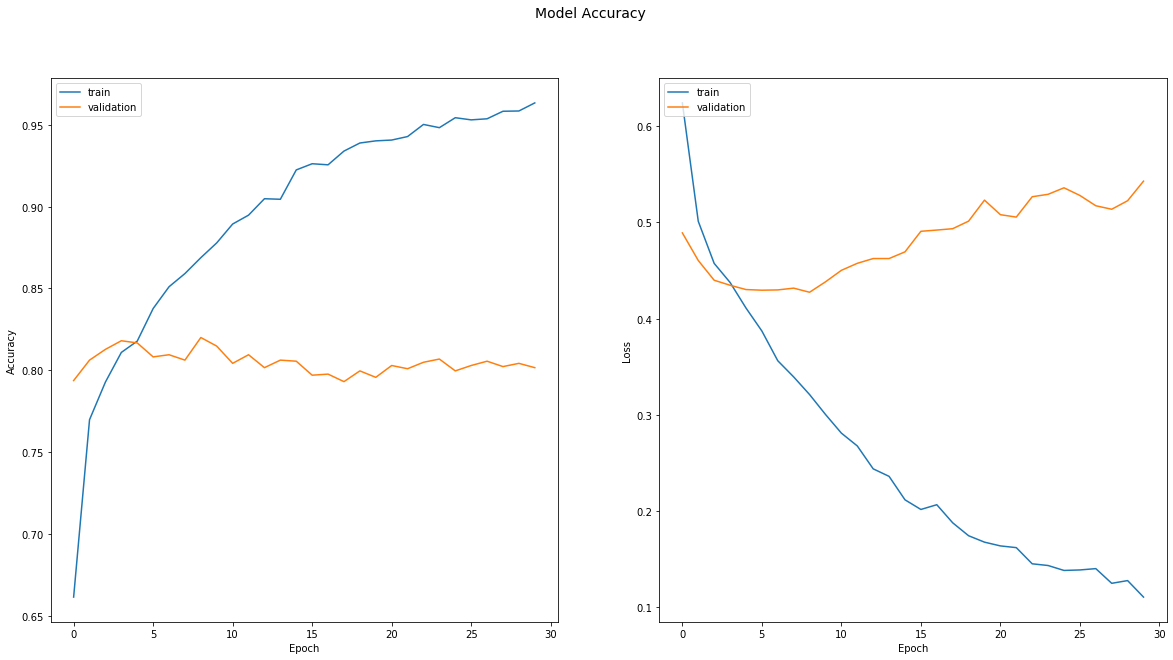

In [96]:
viz.plot_learning_curves(history)

### Training without additional features (Text only)

In [83]:
## splitting the training data into train and testing set

X_train, X_test, y_train, y_test = train_test_split(X, labels, random_state=42, test_size = 0.2, stratify=labels)

In [84]:
model = Sequential()

model.add(Embedding(vocab_size, vec_size, input_length=120, weights=[word_vector_matrix], trainable=False))

model.add(Conv1D(64, 8, activation='relu'))

model.add(MaxPooling1D(2))

model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [85]:
history1 = model.fit(X_train, y_train, epochs=30, validation_data = (X_test, y_test))

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 5s 829us/sample - loss: 0.5645 - accuracy: 0.7197 - val_loss: 0.4589 - val_accuracy: 0.8037
Epoch 2/30
6090/6090 [==============================] - 4s 727us/sample - loss: 0.4767 - accuracy: 0.7860 - val_loss: 0.4388 - val_accuracy: 0.8188
Epoch 3/30
6090/6090 [==============================] - 4s 724us/sample - loss: 0.4442 - accuracy: 0.8028 - val_loss: 0.4279 - val_accuracy: 0.8142
Epoch 4/30
6090/6090 [==============================] - 4s 728us/sample - loss: 0.4243 - accuracy: 0.8171 - val_loss: 0.4204 - val_accuracy: 0.8201
Epoch 5/30
6090/6090 [==============================] - 4s 737us/sample - loss: 0.3969 - accuracy: 0.8278 - val_loss: 0.4222 - val_accuracy: 0.8280
Epoch 6/30
6090/6090 [==============================] - 4s 737us/sample - loss: 0.3630 - accuracy: 0.8468 - val_loss: 0.4387 - val_accuracy: 0.8155
Epoch 7/30
6090/6090 [==============================] - 5s 745us

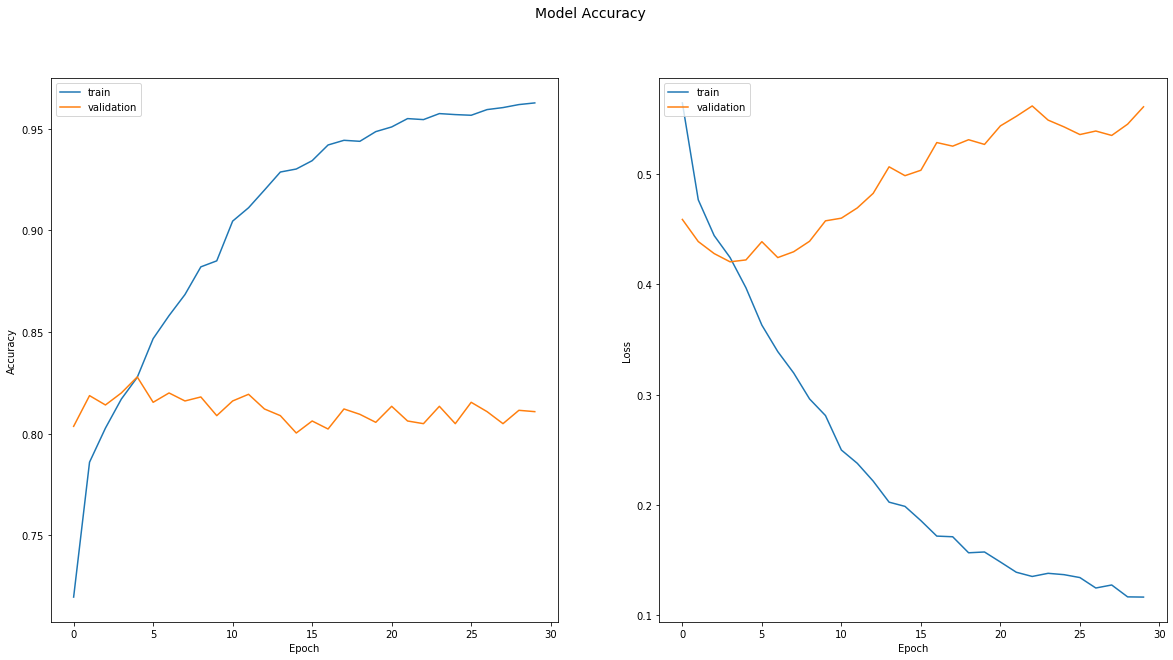

In [97]:
# As shown in the learning curves, CNN model is overfitting.

viz.plot_learning_curves(history1)

## LSTM model

In [87]:
from tensorflow import keras
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate):
    #define inputs
    input_layer = Input(shape = (120,), name = 'nlp_input')
    #meta_input_train = Input(shape = (9, ), name = 'meta_train')
    embed = (Embedding(vocab_size, vec_size, input_length=max_length, weights=[word_vector_matrix], trainable=False))(input_layer)
    
    #add dropout and LSTM layer
    embed = SpatialDropout1D(rate = spatial_dropout)(embed) 
    nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_regularizer = regularizers.l2(1e-4))))(embed)
    
    
    x = Dropout(dropout)(nlp_out)
    pred = Dense(1, activation='sigmoid')(x)
    
    #compile
    model = Model(inputs = input_layer, outputs = pred)
    op = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = op, metrics = ['accuracy'])
    
    return model

In [88]:
#define dropout/learning rates
spatial_dropout = 0.2
dropout = 0.5
recurrent_dropout = 0
learning_rate = 0.01

model1 = create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nlp_input (InputLayer)       [(None, 120)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 120, 200)          3155200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 120, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               240800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 3,396,201
Trainable params: 241,001
Non-trainable params: 3,155,200
_____________________________________________

In [90]:
#fit model
history2 = model1.fit(X_train, y_train, validation_data = (X_test, y_test),
         epochs = 20, batch_size = 23, verbose = 1)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 22s 4ms/sample - loss: 0.6983 - accuracy: 0.7829 - val_loss: 0.6536 - val_accuracy: 0.8063
Epoch 2/20
6090/6090 [==============================] - 21s 4ms/sample - loss: 0.6957 - accuracy: 0.7805 - val_loss: 0.6321 - val_accuracy: 0.8030
Epoch 3/20
6090/6090 [==============================] - 21s 4ms/sample - loss: 0.6861 - accuracy: 0.7826 - val_loss: 0.6434 - val_accuracy: 0.8056
Epoch 4/20
6090/6090 [==============================] - 22s 4ms/sample - loss: 0.6831 - accuracy: 0.7814 - val_loss: 0.6206 - val_accuracy: 0.8109
Epoch 5/20
6090/6090 [==============================] - 21s 3ms/sample - loss: 0.6711 - accuracy: 0.7829 - val_loss: 0.6186 - val_accuracy: 0.8122
Epoch 6/20
6090/6090 [==============================] - 21s 4ms/sample - loss: 0.6693 - accuracy: 0.7833 - val_loss: 0.6218 - val_accuracy: 0.8089
Epoch 7/20
6090/6090 [==============================] - 22s 4ms/sample

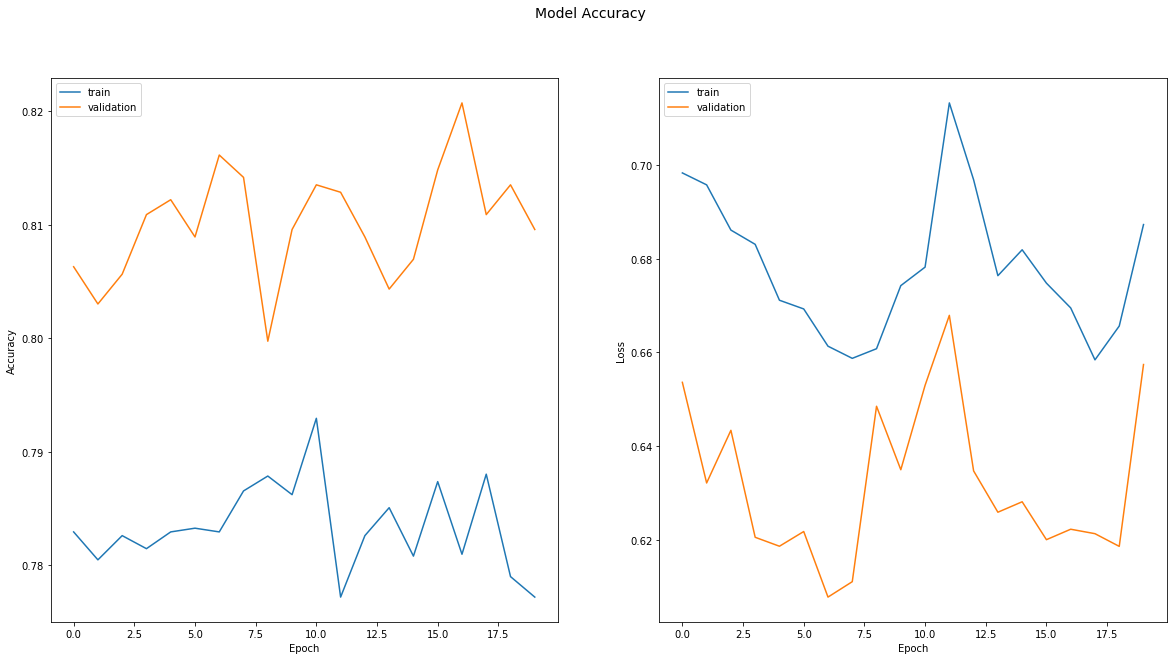

In [98]:
#LSTM model is not showing superb performace but it is not overfitting

# Data clearning and adding more data can definitely help enhance the accuracy of the model

viz.plot_learning_curves(history2)